In [1]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [5]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [6]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/bee/validation/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/bee/annotations/validation.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000051501.jpg', '000000051602.jpg', '000000051656.jpg', '000000051770.jpg', '000000052209.jpg', '000000052239.jpg', '000000052248.jpg', '000000052271.jpg', '000000052328.jpg', '000000052361.jpg', '000000052413.jpg', '000000052563.jpg', '000000052583.jpg', '000000052587.jpg', '000000052738.jpg', '000000052799.jpg', '000000052861.jpg', '000000053184.jpg', '000000053247.jpg', '000000053341.jpg', '000000053573.jpg', '000000053614.jpg', '000000053776.jpg', '000000053802.jpg', '000000053827.jpg', '000000053842.jpg', '000000053857.jpg', '000000053866.jpg', '000000053890.jpg', '000000053916.jpg']
30


In [7]:
s_1 = []
s_2 = []
s_3 = []

In [38]:
c_1_0001 = []
c_2_0001 = []
c_3_0001 = []

c_1_001 = []
c_2_001 = []
c_3_001 = []

c_1_01 = []
c_2_01 = []
c_3_01 = []

c_1_p1 = []
c_2_p1 = []
c_3_p1 = []

c_1_1 = []
c_2_1 = []
c_3_1 = []

c_1_5 = []
c_2_5 = []
c_3_5 = []

In [143]:
cu_1 = []
cu_2 = []
cu_3 = []
c_1_1 = []
c_2_1 = []
c_3_1 = []

c_1_5 = []
c_2_5 = []
c_3_5 = []

1 of 8: 100/0/standard 

500 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b4dc0b70>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=83, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=83, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=18, image_width=2560, image_height=1440, mode=xyxy)
51501
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b58d2c88>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=43, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=43, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b58d2a58>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=53, image_width=1422, image

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b5cb8080>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=67, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=67, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b5bde1d0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=74, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=74, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
53776
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b5bde828>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=60, image_width=1422, image_height

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b4d4d470>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=27, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=27, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=10, image_width=2560, image_height=1440, mode=xyxy)
52413
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b4d4da58>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=57, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=57, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=11, image_width=2560, image_height=1440, mode=xyxy)
52563
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b4d4d710>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=90, image_width=1422, image_

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b57932b0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=86, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=86, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=20, image_width=2560, image_height=1440, mode=xyxy)
51501
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b4ddbb00>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=52, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=52, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b4ddb438>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=55, image_width=1422, image_height

53573
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b59ad4a8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=63, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=63, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b59ad898>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=75, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=75, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
53776
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b59b77b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=73, image_width=1422, image_

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05ac8c2a20>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=25, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=25, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=10, image_width=2560, image_height=1440, mode=xyxy)
52413
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05ac8c2128>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=57, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=57, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=11, image_width=2560, image_height=1440, mode=xyxy)
52563
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b05b4dcb940>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
[BoxList(num_boxes=83, image_width=1422, image_

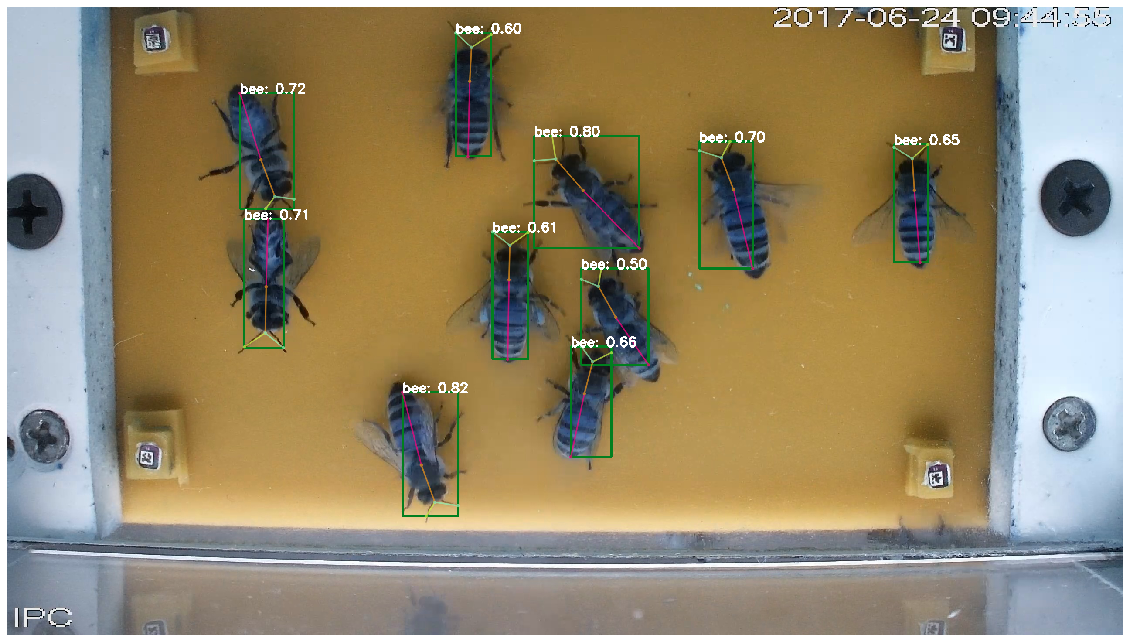

In [181]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

data_size = "25"
its = range(3000,5001,1000)
its = range(1000,1501,1000)
its = range(500,3501,1000)

sts = ["standard_res1/3","standard_res_f5_test_.001_1/3","standard_res_f65_test_.0003_1/3"]
cs = ["combined_res5/3","combined_res_f5_test_.001_5/3","combined_res_f65_test_.0003_5/3"]

loss = cs[2]
#its = [1500]
for it in its:
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'bee', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[0]]
    for idx, image in enumerate(test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        plt.gca().invert_yaxis()
        imshow(predictions[:, :, [2, 1, 0]])
        plt.gca().invert_yaxis()

        for p in data_an['images'][:]:
            if (str(p['file_name']) == test_files[idx] ):
                im_id = p['id']         
        print(im_id)
        for p in data_an['annotations'][:]:
            if ((p['image_id']) == im_id ):
                #print(p['id'])
                #bb = p["segmentation"]#p['bbox']
                bb = p['bbox']
                #bb = bb[0]
                #print('bb', bb)
                bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                #print('bbf', bb_f)
                bbox = bounding_box(bb_f)
                cent_val = get_centroid(bbox)
                dists = []
                #print(cent_val)
                for index, p_bbox in enumerate(bboxes):
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                    #print(dist)
                min_idx = dists.index(min(dists))
                #print("min id", min_idx)
                kps_val = p["keypoints"]
                #print('kps val', kps_val)
                # comment for test and remove og
                #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                #print('kps val', kps_val)
                kps_pred = kps[min_idx].tolist()
                kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                kps_pl = list(chain.from_iterable(kps_pred_list))
                #print("kps val", kps_pred)
                #print("kp pred listt", kps_pred_list)
                diff_vec = np.array(kps_val) - np.array(kps_pl)
                #print(diff_vec)
                #print(diff_vec*diff_vec)
                diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                #print(diff_vec_sum_sq)
                mse_per_bee.append(diff_vec_sum_sq)

        mse_per_image = sum(mse_per_bee)
        #print("mse", mse_per_image)
        #print("mse", mse_per_bee)
        mse_final = mse_per_image/len(mse_per_bee)
        mse_total.append(mse_final)
        #print("mse final", mse_final)


        #img3 = predictions[:, :, [2, 1, 0]]
        #b,g,r = cv2.split(img3)       # get b,g,r
        #img3 = cv2.merge([r,g,b])     # switch it to rgb
        #im = axes[idx][2].imshow(img3)
        #axes[idx][2].invert_yaxis()
        #plt.savefig(base_file + '_reg.png')
    print("mse total for all images", mse_total)
    print(sum(mse_total))
    mse_test = sum(mse_total)/len(mse_total)
    c_3_5.append(mse_test)
    print("mse yo", mse_test)


In [182]:
#print(s_1, len(s_1))
#print(s_2, len(s_2))
#print(s_3, len(s_3))
#452498234004, 9133.592689629197, 7965.038921178797, 7353.186608055335]
print(c_1_5,len(c_1_5))
print(c_2_5,len(c_2_5))
print(c_3_5,len(c_3_5))
#s_1 = [88186.82241088747, 17781.53153187159, 11009.73844185224, 16453.053003257646, 11392.85310484681, 8881.294569746264]


[15998.460684629277, 12913.9392567334, 14518.611876688252, 10530.323694708484, 13852.89933498343, 14425.959099338415, 12002.238844846304, 10692.796519557805] 8
[15115.709436023173, 35328.75997358259, 10131.274059271782, 8834.046285959184, 11704.117667381339, 10988.491385556668, 11051.457863219293, 11932.475624386383] 8
[11985.34281942153, 20181.813446120745, 10445.369201559135, 10064.30837548669, 10455.111315327586, 11565.538177730858, 9663.764053267912, 10602.104098067623] 8


In [192]:
import numpy as np
bu = np.array([7200])
bu = (np.repeat(bu, 8, axis=0)).tolist()
print(bu)
td = np.array([6900])
td = np.repeat(td, 8, axis=0).tolist()
print(td)

[7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200]
[6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900]


In [190]:
# make avgs
c5 = []
for s1,s2,s3 in zip(c_1_5,c_2_5,c_3_5):
    c5.append(((s1+s2+s3)/3))
print(c5,len(cp1))

[14366.504313357995, 22808.170892145583, 11698.418379173056, 9809.559452051451, 12004.042772564118, 12326.66288754198, 10905.820253777836, 11075.792080670604] 8


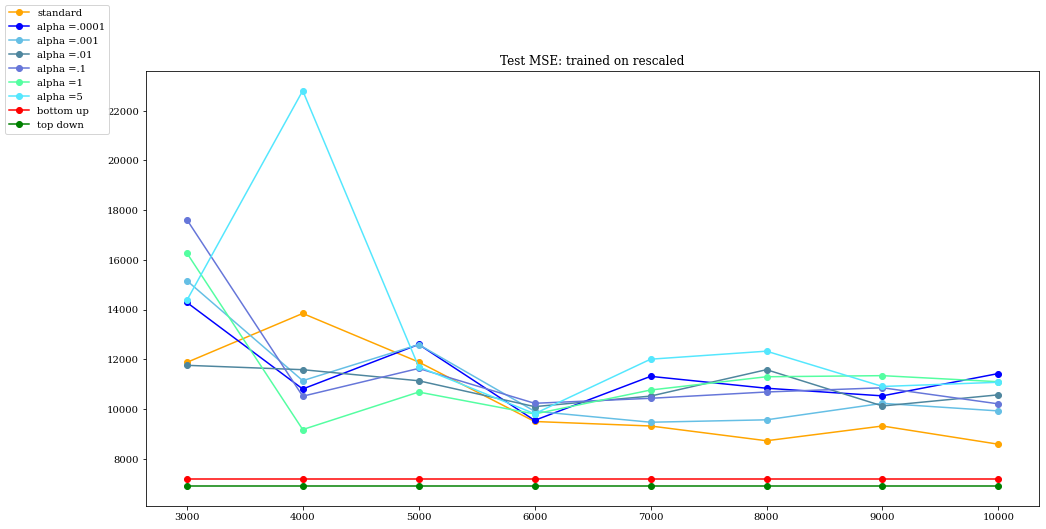

In [193]:
it7 = range(3000,10001,1000)
it3 = range(3000,10001,1000)
#it7=it5[2:]
it_c = range(3000,10001,500)
#it2 = range(8000,10001,500)
#it3 = range(9500,10001,500)
it2 = range(5500,10001,500)
it1 = range(7000,10001,500)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
ax.title.set_text("Test MSE: trained on rescaled")
colors = ['r','b','y','g']

#plt.plot(it7, s_1[2:], '-o', c='orange', label="standard")
#plt.plot(it7, s_2[2:], '-o', c='orange', label="standard")
#plt.plot(it7, s_3[2:], '-o', c='orange', label="standard")
plt.plot(it7, sa, '-o', c='orange', label="standard")

#plt.plot(it3, c_1_0001, '-o', c='blue', label="alpha =.0001")
#plt.plot(it3, c_2_0001, '-o', c='blue', label="alpha =.0001")
#plt.plot(it3, c_3_0001, '-o', c='blue', label="alpha =.0001")
plt.plot(it3, c0001, '-o', c='blue', label="alpha =.0001")

#plt.plot(it3, c_1_001, '-o', c='#65BFE5', label="alpha =.001")
#plt.plot(it3, c_2_001, '-o', c='#65BFE5', label="alpha =.001")
#plt.plot(it3, c_3_001, '-o', c='#65BFE5', label="alpha =.001")
plt.plot(it3, c001, '-o', c='#65BFE5', label="alpha =.001")

#plt.plot(it3, c_1_01, '-o', c='#4E869E', label="alpha =.01")
#plt.plot(it3, c_2_01, '-o', c='#4E869E', label="alpha =.01")
#plt.plot(it3, c_3_01, '-o', c='#4E869E', label="alpha =.01")
plt.plot(it3, c01, '-o', c='#4E869E', label="alpha =.01")

#plt.plot(it3, c_1_p1, '-o', c='#6676D9', label="alpha =.1")
#plt.plot(it3, c_2_p1, '-o', c='#6676D9', label="alpha =.1")
#plt.plot(it3, c_3_p1, '-o', c='#6676D9', label="alpha =.1")
plt.plot(it3, cp1, '-o', c='#6676D9', label="alpha =.1")

#plt.plot(it3, c_1_1, '-o', c='#54FEA1', label="alpha =1")
#plt.plot(it3, c_2_1, '-o', c='#54FEA1', label="alpha =1")
#plt.plot(it3, c_3_1, '-o', c='#54FEA1', label="alpha =1")
plt.plot(it3, c1, '-o', c='#54FEA1', label="alpha =1")

#plt.plot(it3, c_1_5, '-o', c='#54E7FE', label="alpha =5")
#plt.plot(it3, c_2_5, '-o', c='#54E7FE', label="alpha =5")
#plt.plot(it3, c_3_5, '-o', c='#54E7FE', label="alpha =5")
plt.plot(it3, c5, '-o', c='#54E7FE', label="alpha =5")


plt.plot(it7, bu,'-o', c='red', label="bottom up")
plt.plot(it7, td,'-o', c='green', label="top down")

    
fig.legend(loc='upper left')
fig.savefig("combo_st_sleap_un2" +'.png')
plt.show()

In [ ]:
it7 = range(2000,10001,500)
#it7=it5[2:]
it_c = range(3000,10001,500)
#it2 = range(8000,10001,500)
#it3 = range(9500,10001,500)
it2 = range(5500,10001,500)
it1 = range(7000,10001,500)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
ax.title.set_text("Test MSE: trained on rescaled")
colors = ['r','b','y','g']

plt.plot(it7, s_1[2:], '-o', c='orange', label="standard lr=.01,lr=.001,lr=.0003")
#plt.errorbar(it7, s_avg[5:], yerr=s_diff[5:], xerr=None, fmt='', ecolor='grey',c='grey',label="standard lr=.01,lr=.001,lr=.0003"
            #,elinewidth=None, capsize=16, capthick=3)
#plt.errorbar(it1, c_avg[1:], yerr=c_diff[1:], xerr=None, fmt='', ecolor='blue',c='blue',label="combined lr=.01,lr=.001,lr=.0003",capsize=16, capthick=3)
#plt.errorbar(it2, cu_avg, yerr=cu_diff, xerr=None, fmt='', ecolor='purple',c='purple',label="combined with unlabeled  lr=.01,lr=.001,lr=.0003",capsize=16, capthick=3)
plt.plot(it_c, c_1, '-o', c='blue', label="alpha=.001, combined lr=.01,lr=.001,lr=.0003")
plt.plot(it_c, com0001, '-o', c='#7276E8', label="alpha=.0001, combined lr=.01,lr=.001,lr=.0003")
plt.plot(it_c, comp00001, '-o', c='#33B0E3', label="alpha=.00001, combined lr=.01,lr=.001,lr=.0003")

plt.plot(it_c, comp1, '-o', c='#9DE2FF', label="alpha=.1, combined lr=.01,lr=.001,lr=.0003")


plt.plot(it2, cu_1, '-o', c='grey', label="combined unlabeled beta = 1, = lr=.01,lr=.001,lr=.0003")
plt.plot(it2, cu_2, '-o', c='pink', label="combined unlabeled beta = 10,lr=.01,lr=.001,lr=.0003")
plt.plot(it1, cu_1_001, '-o', c='brown', label="combined unlabeled beta = 1,.001,lr=.01,lr=.001,lr=.0003")
#plt.plot(it2, cu_avg, '-o', c='purple', label="combined with unlabeled  lr=.01,lr=.001,lr=.0003")


#plt.plot(it7, small_c,'-o', c='blue', label="combined")
plt.plot(it7, bu[0:17],'-o', c='red', label="bottom up")
plt.plot(it7, td[0:17],'-o', c='green', label="top down")
    
fig.legend(loc='upper left')
fig.savefig("combo_st_sleap_un2" +'.png')
plt.show()